In [1]:
import random
import numpy as np
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn.functional as F

In [2]:
def read_paths(folder_path):
    person_folders = [os.path.join(folder_path, folder) for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
    img_paths = []

    # Collect paths to all images
    for person_folder in person_folders:
        for img_file in os.listdir(person_folder):
            if img_file.endswith(".jpg") or img_file.endswith(".png"):
                img_paths.append(os.path.join(person_folder, img_file))
    return img_paths



In [3]:
img_paths=read_paths('/kaggle/input/celebahq/celeba_hq/train')
num_of_trainImgs=len(img_paths)
print(num_of_trainImgs)
val_paths=read_paths('/kaggle/input/celebahq/celeba_hq/val')
print(len(val_paths))

28000
2000


In [4]:
masked_folder = '/kaggle/working/masked_imgs'
os.makedirs(masked_folder, exist_ok=True)
mask_folder = '/kaggle/working/masks'
os.makedirs(mask_folder, exist_ok=True)
# box_folder = '/kaggle/working/boxs'
# os.makedirs(box_folder, exist_ok=True)
masked_paths=[]
masks_paths=[]
# box_paths=[]
def default_loader(path):
    return Image.open(path)

def resize(image, height, width):
    return image.resize((width, height), Image.BICUBIC)

def bbox(opt):
    # Here, you can define your method to generate a bounding box.
    # For this example, let's assume we randomly generate the box location.
    y = random.randint(0, opt['img_shape'][1] - opt['mask_height'])
    x = random.randint(0, opt['img_shape'][2] - opt['mask_width'])
    return (x, y, x + opt['mask_width'], y + opt['mask_height'])

def bbox2mask(box, opt):
    mask = np.zeros((opt['img_shape'][1], opt['img_shape'][2]), dtype=np.float32)
    mask[box[1]:box[3], box[0]:box[2]] = 1.0  # Apply the mask inside the bounding box
    return torch.from_numpy(mask).unsqueeze(0)  # Convert to tensor with channel dimension


In [7]:
def apply_mask_to_images(image_list, opt, mask_type='regular'):
    index=0
    # Transform to convert image to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    # Loop through image paths in the list
    for impath in image_list:
        # Load and resize the image
        img = default_loader(impath)
        img = resize(img, opt['img_shape'][1], opt['img_shape'][2])
        img_tensor = transform(img) 
        if mask_type == 'regular':
            # Get the bounding box for the mask
            box = bbox(opt)  # Randomly generated bounding box
            mask_tensor = bbox2mask(box, opt)  # Create the mask tensor
            bbox_tensor = torch.from_numpy(np.array(box))  # Convert bbox to tensor

        # Determine the position for applying the mask
        if opt['mask_pos'] == 'random':
            # Randomly place the mask
            box = bbox(opt)
            mask_tensor = bbox2mask(box, opt)
        elif opt['mask_pos'] == 'center':
            # Center the mask on the image
            center_x = (opt['img_shape'][2] - opt['mask_width']) // 2
            center_y = (opt['img_shape'][1] - opt['mask_height']) // 2
            box = (center_x, center_y, center_x + opt['mask_width'], center_y + opt['mask_height'])
            mask_tensor = bbox2mask(box, opt)
            #mask
        mask_numpy = mask_tensor.squeeze().cpu().numpy()  # Remove channel dimension if present
        mask_numpy = np.uint8(mask_numpy * 255)  # Convert to 0-255 for visualization
        mask_pil = Image.fromarray(mask_numpy)  # Convert mask to PIL image
        mask_save_path = os.path.join(mask_folder, f"{index}_mask.jpg")
        masks_paths.append(mask_save_path)
        mask_pil.save(mask_save_path)

        # # bounding box 
        # bbox_save_path = os.path.join(box_folder, f"{index}_bbox.txt")
        # box_paths.append(bbox_save_path)
        # with open(bbox_save_path, 'w') as f:
        #     f.write(f"{box[0]} {box[1]} {box[2]} {box[3]}")  # Save bbox as x_min y_min x_max y_max

        # # Plot the mask using plt
        # plt.imshow(mask_numpy, cmap='gray')  # Use a grayscale colormap for the binary mask
        # plt.title(f"Mask for image: {os.path.basename(impath)}")
        # plt.axis('off')  # Turn off axis labels
        # plt.show()

        masked_image = img_tensor * (1. - mask_tensor) 
        img_numpy = img_tensor.permute(1, 2, 0).cpu().numpy()  
        masked_numpy = masked_image.permute(1, 2, 0).cpu().numpy()
        # Denormalize images to [0, 1] for visualization
        img_numpy = (img_numpy + 1) / 2
        masked_numpy = (masked_numpy + 1) / 2
        masked_image_pil = Image.fromarray((masked_numpy * 255).astype(np.uint8))  # Convert to PIL image
        masked_filename = os.path.basename(f"{index}.jpg")
        masked_save_path = os.path.join(masked_folder, masked_filename)
        masked_image_pil.save(masked_save_path)
        masked_paths.append(masked_save_path)
        index+=1
        


In [8]:
# Example usage
opt = {
    'fineSize': 256,  # Image size (e.g., 256x256)
    'mask_height': 64,  # Mask height
    'mask_width': 64,  # Mask width
    'vertical_margin': 10,  # Margin for mask position
    'horizontal_margin': 10,
    'img_shape': [3, 256, 256],  # Image shape (channels, height, width)
    'max_delta_height': 16,  # Max variation in mask height
    'max_delta_width': 16,  # Max variation in mask width
    'mask_pos': 'random',  # Mask position ('random' or 'center')
    'mask_list': None  # You could provide a list of mask file paths here for 'irregular' masks
}
apply_mask_to_images(img_paths, opt, mask_type='regular')

In [11]:
masked_val_folder = '/kaggle/working/masked_imgs_val'
os.makedirs(masked_val_folder, exist_ok=True)
mask_val_folder = '/kaggle/working/masks_val'
os.makedirs(mask_val_folder, exist_ok=True)
masked_paths_val=[]
masks_paths_val=[]


In [12]:
def apply_mask_to_val_images(image_list, opt, mask_type='regular'):
    index=0
    # Transform to convert image to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    # Loop through image paths in the list
    for impath in image_list:
        # Load and resize the image
        img = default_loader(impath)
        img = resize(img, opt['img_shape'][1], opt['img_shape'][2])
        img_tensor = transform(img) 
        if mask_type == 'regular':
            # Get the bounding box for the mask
            box = bbox(opt)  # Randomly generated bounding box
            mask_tensor = bbox2mask(box, opt)  # Create the mask tensor
            bbox_tensor = torch.from_numpy(np.array(box))  # Convert bbox to tensor

        # Determine the position for applying the mask
        if opt['mask_pos'] == 'random':
            # Randomly place the mask
            box = bbox(opt)
            mask_tensor = bbox2mask(box, opt)
        elif opt['mask_pos'] == 'center':
            # Center the mask on the image
            center_x = (opt['img_shape'][2] - opt['mask_width']) // 2
            center_y = (opt['img_shape'][1] - opt['mask_height']) // 2
            box = (center_x, center_y, center_x + opt['mask_width'], center_y + opt['mask_height'])
            mask_tensor = bbox2mask(box, opt)
            #mask
        mask_numpy = mask_tensor.squeeze().cpu().numpy()  # Remove channel dimension if present
        mask_numpy = np.uint8(mask_numpy * 255)  # Convert to 0-255 for visualization
        mask_pil = Image.fromarray(mask_numpy)  # Convert mask to PIL image
        mask_save_path = os.path.join(mask_val_folder, f"{index}_mask.jpg")
        masks_paths_val.append(mask_save_path)
        mask_pil.save(mask_save_path)

        # # bounding box 
        # bbox_save_path = os.path.join(box_folder, f"{index}_bbox.txt")
        # box_paths.append(bbox_save_path)
        # with open(bbox_save_path, 'w') as f:
        #     f.write(f"{box[0]} {box[1]} {box[2]} {box[3]}")  # Save bbox as x_min y_min x_max y_max

        # # Plot the mask using plt
        # plt.imshow(mask_numpy, cmap='gray')  # Use a grayscale colormap for the binary mask
        # plt.title(f"Mask for image: {os.path.basename(impath)}")
        # plt.axis('off')  # Turn off axis labels
        # plt.show()

        masked_image = img_tensor * (1. - mask_tensor) 
        img_numpy = img_tensor.permute(1, 2, 0).cpu().numpy()  
        masked_numpy = masked_image.permute(1, 2, 0).cpu().numpy()
        # Denormalize images to [0, 1] for visualization
        img_numpy = (img_numpy + 1) / 2
        masked_numpy = (masked_numpy + 1) / 2
        masked_image_pil = Image.fromarray((masked_numpy * 255).astype(np.uint8))  # Convert to PIL image
        masked_filename = os.path.basename(f"{index}.jpg")
        masked_save_path = os.path.join(masked_val_folder, masked_filename)
        masked_image_pil.save(masked_save_path)
        masked_paths_val.append(masked_save_path)
        index+=1
        


In [13]:
apply_mask_to_val_images(val_paths, opt, mask_type='regular')

In [16]:
from torchvision import transforms
class FacialInpaintingDataset(Dataset):
    def __init__(self, image_paths, mask_paths,masked_paths, transform=None):
        self.image_paths = image_paths  
        self.mask_paths = mask_paths  
        self.masked_paths=masked_paths   
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Load masked image
        mask_img_path = self.masked_paths[idx]
        masked_img = Image.open(mask_img_path).convert('RGB')

        # Load the mask
        mask_path = self.mask_paths[idx]
        mask = Image.open(mask_path).convert('L')  # 'L' mode for grayscale (binary mask)

        # Apply any transformations (e.g., resizing, normalization)
        if self.transform:
            img = self.transform(img)
            masked_img = self.transform(masked_img)
            mask = transforms.ToTensor()(mask)  # Convert to tensor (shape [1, H, W])

        return {
            'input': masked_img,  # Masked image
            'target': img,        # Original image
            'mask': mask,         # Mask tensor
            # 'bbox': bbox_tensor,  # Bounding box tensor
            'path': img_path      # Path to the image (useful for debugging or saving output)
        }


In [17]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

dataset = FacialInpaintingDataset(image_paths=img_paths, 
                                  mask_paths=masks_paths, 
                                  masked_paths=masked_paths, 
                               
                                  transform=transform)
val_dataset=FacialInpaintingDataset(image_paths=val_paths, 
                                  mask_paths=masks_paths_val, 
                                  masked_paths=masked_paths_val, 
                                   
                                  transform=transform)
# Create the validation DataLoader
val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
# Create the DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
sample = dataset[0]  # Get the first item in the dataset

print("Input (masked image) shape:", sample['input'].shape)  # Masked image tensor shape
print("Target (original image) shape:", sample['target'].shape)  # Original image tensor shape
print("Mask shape:", sample['mask'].shape)  # Mask tensor shape
print("Image path:", sample['path'])  # Path to the image

Input (masked image) shape: torch.Size([3, 256, 256])
Target (original image) shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])
Image path: /kaggle/input/celebahq/celeba_hq/train/female/130301.jpg


In [19]:
import torch
import torch.nn as nn

def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=1, activation='relu'):
    padding = kernel_size // 2 if padding == 1 else padding  # default padding logic
    activation_layer = nn.ReLU(inplace=True) if activation == 'relu' else None
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        activation_layer
    )

class Generator(nn.Module):
    def __init__(self, in_nc, out_nc, nf=64, n_res=6):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(  
            conv_block(in_nc, nf, 3, stride=1),  # Input: [4, 256, 256]
            conv_block(nf, nf*2, 3, stride=2),  # [64, 128, 128]
            conv_block(nf*2, nf*4, 3, stride=2)  # [128, 64, 64]
        )

        # Residual blocks for feature refinement (simplified)
        self.residual_blocks = nn.Sequential(
            *[conv_block(nf*4, nf*4, 3, stride=1) for _ in range(n_res)]
        )

        self.decoder = nn.Sequential(
            conv_block(nf*4, nf*2, 3, stride=1),
            nn.ConvTranspose2d(nf*2, nf, kernel_size=4, stride=2, padding=1),  # [128, 128, 128]
            nn.ConvTranspose2d(nf, out_nc, kernel_size=4, stride=2, padding=1),  # [256, 256, 256]
            nn.Tanh()  # Output: [-1, 1] for images
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x



In [20]:
import torch
import torch.nn as nn
import torchvision

class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=(1, 6, 11, 20, 29), use_input_norm=True):
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = torchvision.models.vgg19(pretrained=True).features
        self.layers = nn.ModuleList([
            vgg19[:feature_layer[0]],  # Layer 0-1
            vgg19[feature_layer[0]:feature_layer[1]],  # Layer 2-6
            vgg19[feature_layer[1]:feature_layer[2]],  # Layer 7-11
            vgg19[feature_layer[2]:feature_layer[3]],  # Layer 12-20
            vgg19[feature_layer[3]:feature_layer[4]]   # Layer 21-29
        ])
        self.use_input_norm = use_input_norm
        if self.use_input_norm:
            mean = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            std = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
            self.register_buffer('mean', mean)
            self.register_buffer('std', std)

    def forward(self, x):
        if self.use_input_norm:
            x = (x - self.mean) / self.std

        features = []
        for layer in self.layers:
            x = layer(x)
            features.append(x)
        return features


In [21]:
# Hyperparameters
import torchvision
lr = 1e-3
batch_size = 16
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model, loss functions, and optimizer
generator = Generator(in_nc=4, out_nc=3, nf=64, n_res=6).to(device)

# Initialize the VGG feature extractor (you can specify the layers for feature extraction)
vgg_extractor = VGGFeatureExtractor().to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss()
mse_loss = nn.MSELoss()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 181MB/s]  


In [23]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision

# Optionally, if you want to use a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.5)

# Training function
def train(generator, data_loader, val_data_loader, optimizer_G, vgg_extractor, epochs=10, device='cuda'):
    generator.train()  # Set the model to training mode
    for epoch in range(epochs):
        epoch_loss = 0.0
        perceptual_loss = 0.0
        for i, batch in enumerate(data_loader):
            # Get the real and fake images
            real_images = batch['target'].to(device)
            masked_images = batch['input'].to(device)  # Masked images
            masks = batch['mask'].to(device)  # Mask tensor (for conditioning)
            masked_images_with_mask = torch.cat([masked_images, masks], dim=1) 
            # Forward pass through the generator
            fake_images = generator(masked_images_with_mask)
            
            # Calculate pixel-wise loss (MSE)
            loss_pixel = mse_loss(fake_images, real_images)  # Compare generated vs real images

            # Extract features using the VGG extractor (for perceptual loss)
            vgg_real_features = vgg_extractor(real_images)
            vgg_fake_features = vgg_extractor(fake_images)
            
            # Calculate perceptual (feature) loss using MSE between VGG features
            feature_loss = 0.0
            for real, fake in zip(vgg_real_features, vgg_fake_features):
                feature_loss += mse_loss(fake, real.detach())  # We detach real features to avoid gradients
            
            # Combine pixel loss and perceptual loss (you can adjust weights)
            total_loss = loss_pixel + 0.1 * feature_loss  # Adjust 0.1 as a weighting factor

            # Backpropagation
            optimizer_G.zero_grad()
            total_loss.backward()
            optimizer_G.step()

            epoch_loss += loss_pixel.item()
            perceptual_loss += feature_loss.item()

            # Print the training progress
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(data_loader)}], "
                      f"Pixel Loss: {loss_pixel.item():.4f}, Feature Loss: {feature_loss.item():.4f}, "
                      f"Total Loss: {total_loss.item():.4f}")

        # Scheduler step (if you're using one)
        scheduler.step()

        # Validation after each epoch
        validate(generator, val_data_loader, vgg_extractor, device)

        # Save model checkpoint (if needed)
        torch.save(generator.state_dict(), f'/kaggle/working/generator_epoch_{epoch+1}.pth')

        print(f"Epoch [{epoch+1}/{epochs}] completed, Avg Pixel Loss: {epoch_loss / len(data_loader):.4f}, "
              f"Avg Perceptual Loss: {perceptual_loss / len(data_loader):.4f}")

# Validation function
def validate(generator, val_data_loader, vgg_extractor, device):
    generator.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    perceptual_val_loss = 0.0
    with torch.no_grad():
        for batch in val_data_loader:
            real_images = batch['target'].to(device)
            masked_images = batch['input'].to(device)
            masked_images = torch.cat([masked_images, masked_images[:, :1, :, :]], dim=1) 
            
            # Forward pass through the generator
            fake_images = generator(masked_images)
            
            # Calculate pixel-wise loss for the validation set
            loss_pixel = mse_loss(fake_images, real_images)

            # Extract features using the VGG extractor for perceptual loss
            vgg_real_features = vgg_extractor(real_images)
            vgg_fake_features = vgg_extractor(fake_images)
            
            # Calculate perceptual loss using VGG features
            feature_loss = 0.0
            for real, fake in zip(vgg_real_features, vgg_fake_features):
                feature_loss += mse_loss(fake, real.detach())
            
            # Combine the pixel loss and perceptual loss
            total_val_loss = loss_pixel + 0.1 * feature_loss
            val_loss += loss_pixel.item()
            perceptual_val_loss += feature_loss.item()

    print(f"Validation Loss: {val_loss / len(val_data_loader):.4f}, "
          f"Validation Perceptual Loss: {perceptual_val_loss / len(val_data_loader):.4f}")
    
    generator.train()  # Switch back to training mode



In [24]:
train(generator, data_loader, val_data_loader, optimizer_G, vgg_extractor, epochs=10, device='cuda')


Epoch [1/10], Step [0/875], Pixel Loss: 0.4598, Feature Loss: 292.1476, Total Loss: 29.6746
Epoch [1/10], Step [100/875], Pixel Loss: 0.1293, Feature Loss: 138.7901, Total Loss: 14.0083
Epoch [1/10], Step [200/875], Pixel Loss: 0.0864, Feature Loss: 94.2635, Total Loss: 9.5127
Epoch [1/10], Step [300/875], Pixel Loss: 0.0881, Feature Loss: 107.1121, Total Loss: 10.7993
Epoch [1/10], Step [400/875], Pixel Loss: 0.0547, Feature Loss: 81.2278, Total Loss: 8.1775
Epoch [1/10], Step [500/875], Pixel Loss: 0.0318, Feature Loss: 54.8822, Total Loss: 5.5200
Epoch [1/10], Step [600/875], Pixel Loss: 0.0310, Feature Loss: 60.2311, Total Loss: 6.0541
Epoch [1/10], Step [700/875], Pixel Loss: 0.0246, Feature Loss: 48.7495, Total Loss: 4.8996
Epoch [1/10], Step [800/875], Pixel Loss: 0.0287, Feature Loss: 47.8176, Total Loss: 4.8104
Validation Loss: 0.0263, Validation Perceptual Loss: 51.5999
Epoch [1/10] completed, Avg Pixel Loss: 0.0831, Avg Perceptual Loss: 87.0419
Epoch [2/10], Step [0/875], Pi

In [25]:
    # Lists to store training losses
    train_pixel_losses = [0.0831,0.0211,0.0188,0.0146,0.0127,0.0371,0.0126, 0.0124,0.0108, 0.0103]
    train_perceptual_losses = [87.0419,36.3711,33.2655,27.4796,24.5153,42.8261,24.4339,24.2036,21.6949,21.1479]
    
    # Lists to store validation losses
    val_pixel_losses = [0.0263,0.0148,0.0156,0.0146,0.0228, 0.0118,0.0100, 0.0096,0.0100,0.0096]
    val_perceptual_losses = [51.5999,38.0694,40.7097,28.5851,39.8077,29.8034,23.4841,22.5238,24.2222,21.2271]

In [26]:
import matplotlib.pyplot as plt
def plot_losses(train_pixel_losses, train_perceptual_losses, val_pixel_losses, val_perceptual_losses):
    epochs = range(1, len(train_pixel_losses) + 1)
    
    plt.figure(figsize=(12, 6))

    # Plot pixel losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_pixel_losses, label='Train Pixel Loss', color='blue')
    plt.plot(epochs, val_pixel_losses, label='Validation Pixel Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Pixel Loss')
    plt.legend()

    # Plot perceptual losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_perceptual_losses, label='Train Perceptual Loss', color='blue')
    plt.plot(epochs, val_perceptual_losses, label='Validation Perceptual Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Perceptual Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

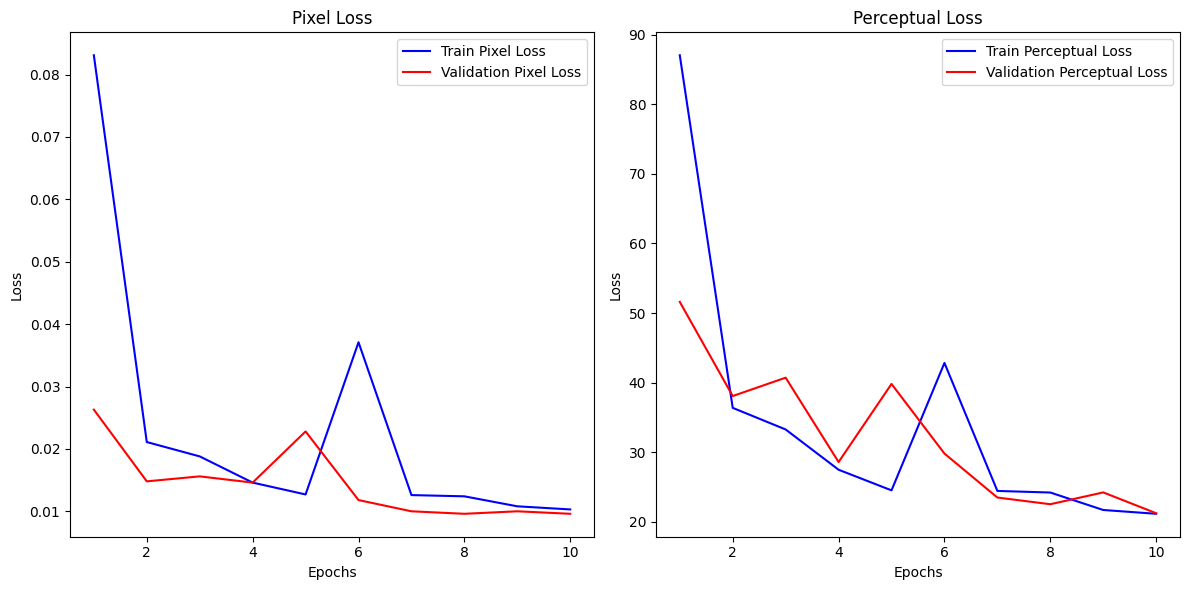

In [27]:
plot_losses(train_pixel_losses,train_perceptual_losses,val_pixel_losses, val_perceptual_losses)

In [32]:

generator = Generator(in_nc=4, out_nc=3).to(device)

# Load the saved model state_dict
checkpoint_path = '/kaggle/working/generator_epoch_10.pth' 
generator.load_state_dict(torch.load(checkpoint_path))
generator.eval() 

<ipython-input-32-c879055fbf54>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(checkpoint_path))


Generator(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (residual_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(

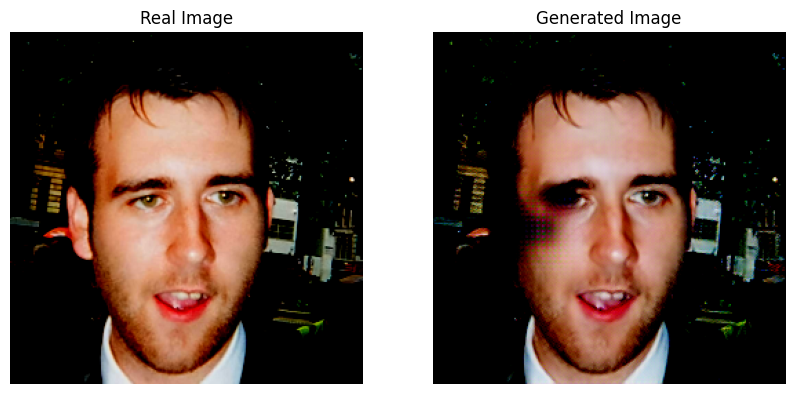

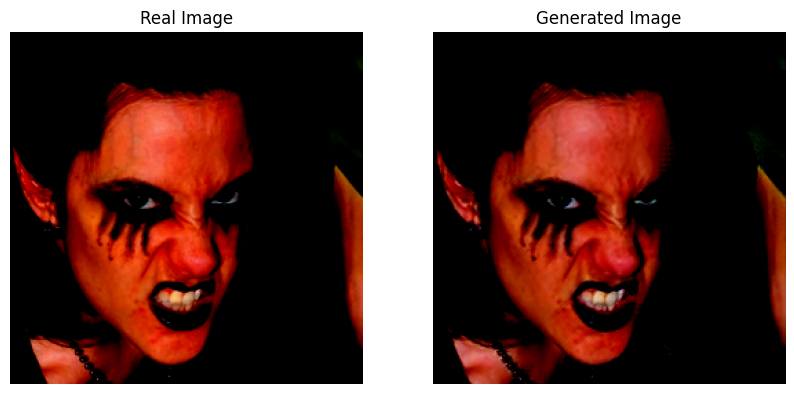

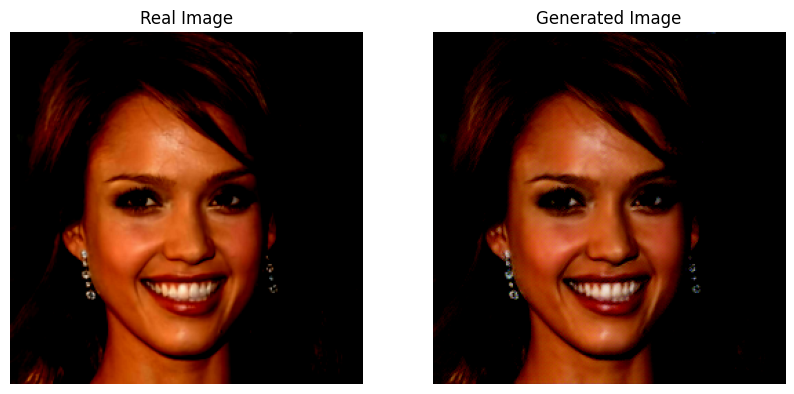

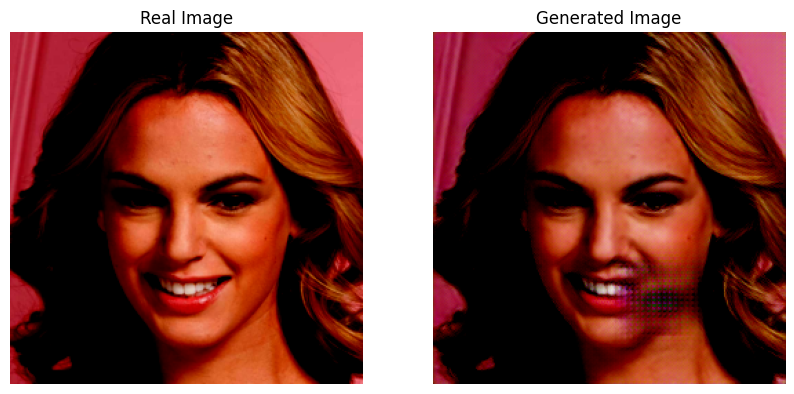

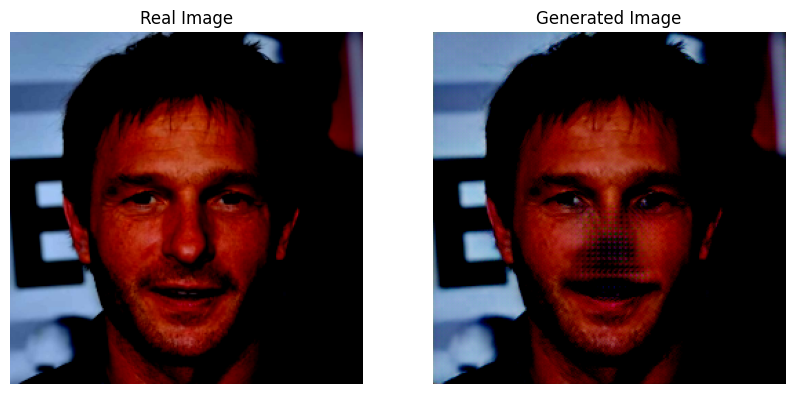

In [33]:
import matplotlib.pyplot as plt

# Function to visualize the results
def visualize_results(generator, test_data_loader, device='cuda', num_images=5):
    generator.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, batch in enumerate(test_data_loader):
            if i >= num_images:  # Limit the number of images to visualize
                break
            
            real_images = batch['target'].to(device)
            masked_images = batch['input'].to(device)
            masked_images = torch.cat([masked_images, masked_images[:, :1, :, :]], dim=1) 

            # Forward pass through the generator to get predictions
            fake_images = generator(masked_images)
            
            # Plot real and generated images side by side for comparison
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            axes[0].imshow(real_images[0].cpu().permute(1, 2, 0).numpy())  # Real image
            axes[0].set_title("Real Image")
            axes[0].axis('off')

            axes[1].imshow(fake_images[0].cpu().permute(1, 2, 0).numpy())  # Generated image
            axes[1].set_title("Generated Image")
            axes[1].axis('off')

            plt.show()

# Call the function to visualize the results
visualize_results(generator, val_data_loader, device='cuda')
